In [37]:
from Mc2PCA_class import Mc2PCA
import numpy as np
from sktime.datasets import load_japanese_vowels
import matplotlib.pyplot as plt 
import pandas as pd
# import train_test_split

from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes):
    # Aligner les étiquettes de cluster avec les vraies étiquettes
    labels = np.zeros_like(y_pred)
    for i in range(max(y_pred) + 1):
        mask = (y_pred == i)
        if np.sum(mask) > 0:
            # Trouver le mode en utilisant np.unique
            unique, counts = np.unique(y_true[mask], return_counts=True)
            labels[mask] = unique[np.argmax(counts)]

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_true, labels)
    # print(conf_matrix)

    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()

def compute_precision(C, G):
    """
    Compute the precision of clustering as described in the provided formula.
    
    C is a list of numpy arrays, where each array represents the indices of MTS objects in the jth predicted cluster.
    G is a list of sets, where each set contains the indices of MTS objects in the ith true group.
    
    Parameters:
    - C: A list of numpy arrays representing the predicted clusters.
    - G: A list of sets representing the true groups.
    
    Returns:
    - The precision of the clustering.
    """
    N = sum(len(c) for c in C)  # Total number of MTS objects
    precision = 0.0
    
    for cj in C:
        if(len(cj) == 0):
            continue
        cj_set = set(cj)
        max_intersection = max(len(cj_set.intersection(gi)) for gi in G)
        # if len(cj) == 0:
        #     continue  # Ignore les clusters vides
        precision += (len(cj) / N) * (max_intersection / len(cj))
        
    return precision

def compute_recall(C, G):
    """
    Compute the recall of clustering.
    
    C is a list of numpy arrays, where each array represents the indices of MTS objects in the jth predicted cluster.
    G is a list of sets, where each set contains the indices of MTS objects in the ith true group.
    
    Parameters:
    - C: A list of numpy arrays representing the predicted clusters.
    - G: A list of sets representing the true groups.
    
    Returns:
    - The recall of the clustering.
    """
    N = sum(len(g) for g in G)  # Total number of MTS objects
    recall = 0.0
    
    for gi in G:
        gi_set = set(gi)
        max_intersection = max(len(gi_set.intersection(cj)) for cj in C)
        recall += (len(gi) / N) * (max_intersection / len(gi))
        
    return recall

def get_p_max(X, K, y_test, metric = "precision", seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array

    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    y_estimate = None
    val = np.inf
    values = []
    p_opt = 0
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        idx_estimate, _, _ = model.fit(X)
        if metric=="precision":
            precision = compute_precision(idx_estimate, idx_test)
            values.append(precision)
        if metric=="ARI":
            y_estimate = np.arange(len(y_test))
            for i in range(len(idx_estimate)):
                y_estimate[idx_estimate[i]] = i + 1 
            ari_score = adjusted_rand_score(y_test.astype(int), y_estimate)
            values.append(ari_score)
    values = np.array(values)
    return np.argmax(values) + 1, values

def get_p_histo(X, K, y_test, seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array
    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    y_estimate = None
    val = np.inf
    precisions = []
    aris = []
    p_opt = 0
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        idx_estimate, _, _ = model.fit(X)
        y_estimate = np.arange(len(y_test))
        for i in range(len(idx_estimate)):
            y_estimate[idx_estimate[i]] = i + 1
        precisions.append(compute_precision(idx_estimate, idx_test))
        aris.append(adjusted_rand_score(y_test.astype(int), y_estimate))
    return precisions, aris

def plot_info(X, K, seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array
    info_tot = []
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        _, _, info_by_cluster = model.fit(X)
        info_tot.append(info_by_cluster)
    plt.figure(figsize=(10, 7))
    info_tot = np.array(info_tot)
    for i in range(K):
        # cum_sum = [sum(info_tot[i][:j+1])  for j in range(len(info_tot[i]))]
        plt.plot(np.arange(1, nbre_features), info_tot[:, i], label = "Cluster " + str(i+1), marker = 'x')
    plt.legend()
    # Ecris les légendes et le titre en anglais 
    plt.title("Cumulative Information for each cluster for different p")
    plt.xlabel("Number of p for Mc2PCA")
    plt.ylabel("Information")
    plt.xticks(np.arange(1, nbre_features))
    plt.show()
    
def plot_hist(X, K, y_test, seuil = 1e-7, max_iter = 50):
    precisions, aris = get_p_histo(X, K, y_test, seuil = 1e-7, max_iter = 50)
    # Positions des barres sur l'axe des abscisses
    x = np.arange(1, len(precisions) + 1)

    # Largeur des barres
    bar_width = 0.35

    # Création des barres
    plt.bar(x - bar_width/2, precisions, width=bar_width, label='Precision')
    plt.bar(x + bar_width/2, aris, width=bar_width, label='ARI')

    # Ajout d'étiquettes et de légendes
    plt.xlabel('Number of p for Mc2PCA')
    plt.title('Comparison of Precision and ARI for different p')
    plt.xticks(x, [str(i) for i in x])
    plt.legend()

    # Afficher le graphique
    plt.show()
    return precisions, aris

def metrics(y_test, idx_estimate,plot=False):
    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    # Conversion des indices en classes
    y_estimate = np.arange(len(y_test))
    for i in range(len(idx_estimate)):
        y_estimate[idx_estimate[i]] = i + 1 


    # Calcul de l'ARI
    ari_score = adjusted_rand_score(y_test.astype(int), y_estimate)


    # Calcul de la précision
    precision = compute_precision(idx_estimate, idx_test)
   

    recall = compute_recall(idx_estimate, idx_test)
    if(plot):
        print("Adjusted Rand Index:", ari_score) 
        print("Precision:", precision)
        print("Recall:", recall)
        # print("varie entre -1 et 1, 1 indique une correspondance parfaite, 0 indique une correspondance aléatoire et -1 indique une correspondance complètement incorrecte")

        plot_confusion_matrix(y_test.astype(int), y_estimate, classes = np.arange(1, np.max(y_test.astype(int) + 1)))
        plt.show()
    return ari_score,precision,recall

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from Mc2PCA_class import Mc2PCA
import numpy as np
from sktime.datasets import load_japanese_vowels
import matplotlib.pyplot as plt 
import pandas as pd
# import train_test_split
from sklearn.model_selection import train_test_split

def generate_correlated_time_series_with_labels(n_samples, n_features, n_timepoints, n_clusters, correlation_strength=0.8, correlation_intra_cluster=1):
    """
    Generates a synthetic multivariate time series dataset with correlations between some dimensions
    and associated cluster labels.
    
    :param n_samples: Number of samples in the dataset
    :param n_features: Number of features (dimensions) for each sample
    :param n_timepoints: Number of time points in each time series
    :param n_clusters: Number of clusters to generate
    :param correlation_strength: Strength of correlation between some features (0 to 1)
    :param correlation_intra_cluster: Strength of correlation within clusters (0 to 2)
    :return: A tuple of a numpy array of shape (n_samples, n_features, n_timepoints) and labels array
    """
    # Generate independent time series for each feature
    time_series = np.random.randn(n_samples, n_features, n_timepoints)
    
    # Introduce correlations between some of the dimensions
    for i in range(1, n_features, 2):  # Correlate features pairwise for simplicity
        #base_series = time_series[:, i-1, :]
        correlated_series = (correlation_strength * time_series[:, i-1, :] + 
                             (1 - correlation_strength) * np.random.randn(n_samples, n_timepoints))
        #correlated_series = np.sin(correlation_strength * np.pi * base_series) + np.random.randn(n_samples, n_timepoints) * (1 - correlation_strength)
        time_series[:, i, :] = correlated_series
    
    # Generate cluster labels
    labels = np.random.randint(n_clusters, size=n_samples)
    
    # Introduce variations within clusters
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]

        for feature in range(n_features):
            cluster_pattern = correlation_intra_cluster * np.random.randn(n_timepoints)  # Unique pattern for this cluster
            for index in cluster_indices:
                time_series[index,feature,:] += cluster_pattern
                #time_series[index,feature-1,:] += cluster_pattern
    
    return time_series, labels

# Parameters for the synthetic MTS
n_samples = 2000
n_features = 100  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_strength = 0.5  
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)

# Generate synthetic data with labels
synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
    n_samples, n_features, n_timepoints, n_clusters, correlation_strength, correlation_intra_cluster
)
X = synthetic_data
y = cluster_labels
y = np.array([str(i + 1) for i in y])

X_df = pd.DataFrame(index=range(n_samples), columns=range(n_features))
for i in range(n_samples):
    for j in range(n_features):
        X_df.at[i, j] = X[i, j, :]
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,"[-1.0413473492322318, -1.2419466385715594, 0.2...","[-0.6869456106978877, 1.4877663174548816, -4.2...","[0.9072280379790784, 0.5540273985348028, -0.12...","[1.1498049971318984, -0.878651036296338, 0.220...","[-0.7790059730367442, 0.3741109010707317, 0.49...","[-0.9568852836771671, 0.5834763191600935, 0.08...","[-0.2089070866803111, -0.34160641356280785, 1....","[0.31436569074314985, 0.4113780246078642, -1.8...","[2.1903378919166614, -0.41350841631314217, -1....","[0.9279531149897546, 1.4407492497473353, -2.27...",...,"[0.5007899725081998, -0.5080857261514699, 0.66...","[-0.8038725504205104, -0.24860534052544528, -0...","[1.7865395530402812, 1.5754497047062193, 1.120...","[2.9611208013909636, 0.781791468505644, -1.301...","[1.825169699218365, 1.9231732950766554, -1.386...","[0.2340173256718336, 0.9988262553317202, -2.70...","[0.8870408103775286, -0.8514935373238515, 2.39...","[0.266373638717022, 1.6524230231636092, 0.8849...","[1.1916088503723739, -0.9076706010452822, 0.43...","[2.450654228403333, -2.0063824529105325, 0.213..."
1,"[-0.8509432515735158, -0.13566669647651036, -0...","[0.5837800057833407, 0.9291903883709418, 0.035...","[0.7857586899413629, 0.6979947701693336, -1.26...","[1.3686934735910221, -1.3236286929447294, -0.0...","[-0.47644069660913757, 2.1632916317696997, -1....","[-0.43971720885341925, 1.508430940188398, -0.5...","[-1.764726932072534, -1.8869324588618803, -0.9...","[-0.7031793071774659, -1.2046478481500769, -0....","[-1.3259219758067986, -0.897234541859207, -0.0...","[-0.13934928452566633, -0.4030929063875175, -0...",...,"[1.3994291339365796, 0.9326292029874358, 1.164...","[1.6632071230326235, 2.1665480901543175, 0.973...","[-2.3369276080722066, 0.09431023861552243, 0.7...","[-0.9214365997558518, 1.557469791613913, 1.598...","[-0.4595600955121836, 1.535405992027297, -0.05...","[-0.8167884736689838, -2.101861947316979, 0.85...","[0.3348799179201769, 0.0914056294746104, 3.757...","[-0.8210305655831939, -1.393203767309175, 1.11...","[-0.6847378821143161, -0.44654937845016596, -1...","[-2.182927857210859, 0.5894682253632183, 3.326..."
2,"[-2.441997629216114, 1.0347359366109654, 2.466...","[-0.0433005968842714, 2.32088592246141, -1.718...","[0.6264528423634913, 2.135973782559303, -1.942...","[1.5570011939079973, -0.07705391071340406, -1....","[0.9309607526474164, 0.49878378820363095, 2.03...","[-0.07718267537471513, 0.021030676322991937, 1...","[1.312932288552335, -1.729556281420857, 1.3839...","[0.12074329967284181, -1.3100630774566577, -1....","[2.43122730571395, 0.49940736121299273, -1.467...","[-0.3128744939204812, 1.5391684159988162, -2.1...",...,"[-0.06844800230314757, 0.8026243474474463, -1....","[-1.1148560698669954, 0.6794760765143446, -1.3...","[-0.5431702258490091, 0.3608866135847771, 1.07...","[1.248460302924774, 0.27072425482016227, -0.07...","[1.6519426099837398, 0.1029356109232451, 0.661...","[0.6002284033405189, 0.3659236637101755, 0.262...","[1.0872492184232976, 0.11903521777208614, -0.0...","[1.5219253205529377, 0.834063758124026, -0.257...","[-2.6344068106167353, -0.4085696928423261, -0....","[0.24022881779191052, -1.6533478555763415, -0...."
3,"[-0.4805465947918883, -3.273989996418546, -0.2...","[0.09309194198229775, -0.9138766249547499, 0.8...","[-1.9671510995102859, 1.9531408571648456, 3.17...","[1.2864738995385572, 0.11185068019241168, 3.25...","[0.4219264793311144, 0.9196309737890789, 0.009...","[0.8461617051671364, 0.8511469619219989, -1.63...","[-0.6642895050579418, 0.18976922239169391, -1....","[1.188707008817548, 1.0431156484896056, 0.6982...","[-0.6029253928097719, -0.22096607098097126, 1....","[-0.29455560982864204, 1.4041058838919835, 0.5...",...,"[2.992637661798614, 0.7574657056814778, 2.2219...","[0.3028010250328915, -1.7208242006514491, -0.9...","[-0.1302603178268843, -1.0525043023298675, -0....","[-0.8967048569247481, -0.8397372596637831, -0....","[-1.7147962453678265, -0.4688971570983939, 2.9...","[0.5137723777073948,

In [62]:

def generate_correlated_time_series_with_labels(n_samples, n_features, n_timepoints, n_clusters, correlation_intra_cluster=0.5):
    """
    Generates a synthetic multivariate time series dataset with random correlations between all features and
    within clusters.
    
    :param n_samples: Number of samples in the dataset
    :param n_features: Number of features (dimensions) for each sample
    :param n_timepoints: Number of time points in each time series
    :param n_clusters: Number of clusters to generate
    :param correlation_intra_cluster: Strength of correlation within clusters (0 to 1)
    :return: A tuple of a numpy array of shape (n_samples, n_features, n_timepoints) and labels array
    """
    # Generate independent time series for each feature
    time_series = np.random.randn(n_samples, n_features, n_timepoints)
    
    # Generate random correlation strengths for each pair of features
    correlation_matrix = np.random.rand(n_features, n_features)
    np.fill_diagonal(correlation_matrix, 1)  # Ensure self-correlation is 1

    # Apply the correlations to the time series data
    for i in range(n_features):
        for j in range(i+1, n_features):
            correlation_strength = correlation_matrix[i, j]
            time_series[:, i, :] += correlation_strength * time_series[:, j, :]
            #time_series[:, j, :] += correlation_strength * time_series[:, i, :]
    
    # Generate cluster labels
    labels = np.random.randint(n_clusters, size=n_samples)
    
    # Introduce intra-cluster correlation
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_pattern = np.random.randn(n_features, n_timepoints)  # Unique pattern for this cluster
        
        # Apply the same pattern to all features within the cluster
        for index in cluster_indices:
            time_series[index, :, :] += correlation_intra_cluster * cluster_pattern
    
    return time_series, labels


# Parameters for the synthetic MTS
n_samples = 2000
n_features = 20  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)

# Generate synthetic data with labels
synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
    n_samples, n_features, n_timepoints, n_clusters, correlation_intra_cluster
)
X = synthetic_data
y = cluster_labels
y = np.array([str(i + 1) for i in y])

X_df = pd.DataFrame(index=range(n_samples), columns=range(n_features))
for i in range(n_samples):
    for j in range(n_features):
        X_df.at[i, j] = X[i, j, :]
X_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"[3.25293344244289, -4.167070832156649, 1.83785...","[2.5438297041519733, -2.199423386210783, -0.72...","[5.16315992591137, -0.5766139340347294, -1.788...","[1.4115661555463062, -4.12200618136205, -0.176...","[4.852002230562599, -2.3068969430776454, -2.83...","[2.8924267779663575, -1.4235096785771089, -1.9...","[0.41248342403716887, -2.1305806301154275, 1.9...","[3.399265474988942, -2.203370912113973, -0.801...","[0.46504099193686654, -2.562194352016572, -2.9...","[0.7613504848775964, -3.2367758127268784, 0.03...","[-0.02429339942912745, 1.5197988363762298, -2....","[0.597222802229223, -3.4961679167863453, 2.021...","[-0.6704203212579788, -0.5351133913990557, 1.6...","[-0.32233559279360247, -3.187293493159993, 1.6...","[1.9336961682138818, 0.7432211535749274, -3.24...","[2.6330561100749685, -2.305435854264523, 1.885...","[2.917128416438946, -3.358406801120728, -2.909...","[3.0266734694033697, -0.3355630866765258, -1.8...","[2.5514407208896612, 0.1437782475036667, -0.23...","[0.07798134208287649, 0.4441515836740692, 0.28..."
1,"[0.6200818923058573, -1.5981267285299339, 2.27...","[-0.6990694936814736, 2.6034833426928072, 1.93...","[-1.8418900618492913, 1.9050073053573797, 2.03...","[0.8900043427539648, 0.9699778690231617, 4.483...","[0.6315702390367672, 0.6494564450874405, 3.003...","[0.1744890489114817, 1.5990208222121818, 0.147...","[-1.0495544317288568, -0.717403918505019, 0.61...","[-1.528481210352485, -0.011012116932153926, 0....","[0.04754238304996372, -0.8094028680959823, 3.9...","[-1.0404901359391556, 3.6665101116621286, 3.13...","[-0.5802890458535044, 0.012626868211758652, -0...","[0.48037152674731287, -0.4643810572467163, 0.1...","[-0.3958675395950588, -1.1909263607093608, 2.3...","[-3.57945207276595, 1.6199796214946214, -1.419...","[3.1418968464890122, -0.022740776965760767, 1....","[-0.15811805201791418, 2.3164000659232, -2.796...","[2.5283583117851958, -1.7178000988649693, -1.6...","[1.5924270439602515, -0.6730112131606656, -0.1...","[0.47236953505798573, -0.7915677537967528, -1....","[0.5400262845596611, 0.08906608054834836, -0.5..."
2,"[-0.2957714818717565, 1.4503201053868586, -0.0...","[1.5096291661021133, 1.1221837315934133, -1.15...","[1.0933923419844118, 3.732071433867792, -1.356...","[1.2424343163388758, 0.9592561997573767, -2.62...","[-0.6894404986077993, 2.3621528203640363, -3.7...","[-2.3264178170072123, 2.968595150949637, -0.61...","[-2.0358515144997784, -2.5520895919511783, 1.6...","[-0.0952103327486915, 0.2310140655762089, -3.3...","[-0.4426776761252891, -1.764931447755612, -3.4...","[0.7548146573970095, -2.2824762089909756, -2.7...","[-1.9817897219416434, 1.4176310862873331, -4.5...","[3.0812687840035737, -0.8487876350180453, -1.6...","[-0.43361691685722703, -1.3262210455312315, -0...","[-2.6159932242672346, -1.0954130316784556, -1....","[-0.25101242304025007, -0.34487819978003353, -...","[1.0683392689849662, -0.5414175994971243, 0.50...","[0.9332529290346627, -2.4515948337282953, -4.1...","[1.051197790367067, -1.4084247432023498, -0.79...","[1.235885453928745, -0.6406478662924273, -1.04...","[0.021849391088093917, -0.26867934619467837, 2..."
3,"[-1.353748288513588, 1.6021554139256995, 2.251...","[-2.035716846660191, -0.9071595865410838, -0.8...","[-1.267209805537506, 1.6245443752338167, -0.41...","[-2.6335486604294758, -0.052854490273354204, 1...","[-0.09243627452462833, 2.205165096590986, 0.17...","[-3.0155635008823793, 3.992034030029964, -0.85...","[-1.7411197191531607, -2.8763390432088594, 2.4...","[-0.4078993993459916, -2.9579328332852834, 0.0...","[-1.5641148410891033, -1.0345614110835304, -0....","[-0.9850955818974029, -3.627458670962965, -0.0...","[-0.6279615770872216, -1.4480435629164368, -0....","[2.958808146472479, -3.883393562789343, 0.7452...","[0.32823417490481543, -3.8892845585532014, 1.5...","[-1.9403039896879961, -4.629151483096736, 1.42...","[-1.1877297770327817, -0.7860024045398389, -1....","[-0.13925025667430715, -0.97044521655461

 62%|██████▏   | 31/50 [00:06<00:03,  5.11it/s]


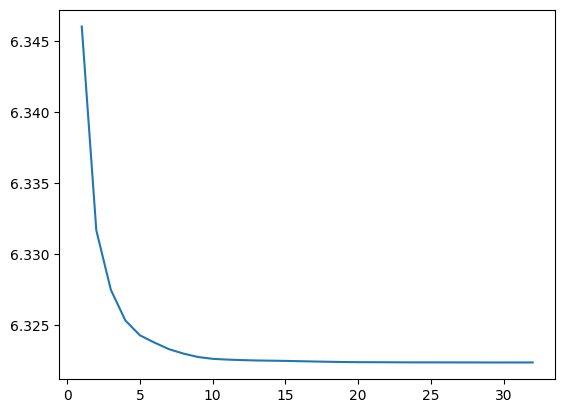

Adjusted Rand Index: 0.06455015218724527
Precision: 0.4630000000000001
Recall: 0.46299999999999997


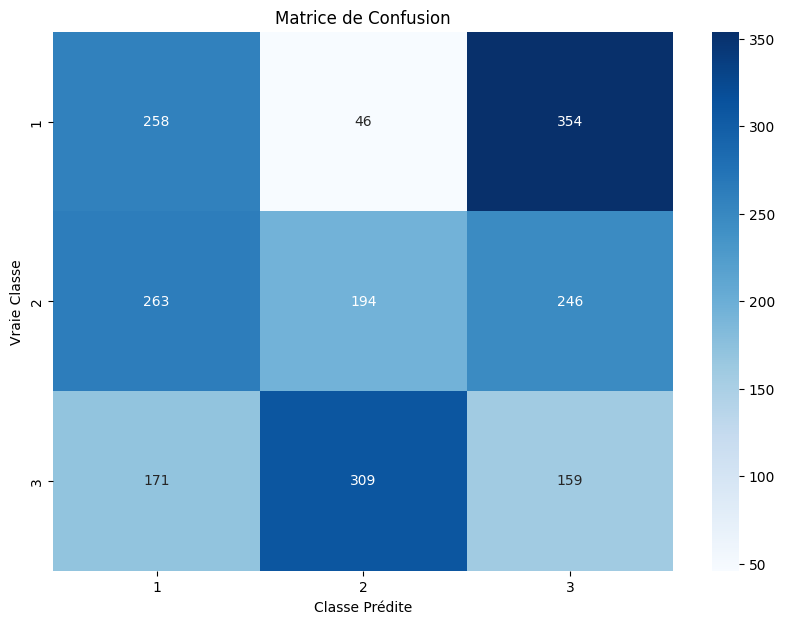

(0.06455015218724527, 0.4630000000000001, 0.46299999999999997)

In [63]:

K = n_clusters
p = 3
seuil = 1e-7
model = Mc2PCA(K, p, seuil, max_iter=50)
idx, E, info_by_cluster = model.fit(X_df)
plt.plot(E)
plt.show()
metrics(y, idx, plot=True)

In [6]:
# base parameters
n_samples = 2000
n_features = 6  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_strength = 0.5  
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)
K = n_clusters
seuil = 1e-7

In [ ]:
# ari_scores=[]
# precisions=[]
# recalls=[]
# df = pd.DataFrame(columns=["nb_samples","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])
# for nb_samples in [100, 500, 1000, 2000, 5000]:
#     print(nb_samples)
#     for i in range(20):
#         np.random.seed(i)
#         # Generate synthetic data with labels
#         synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
#             nb_samples, n_features, n_timepoints, n_clusters, correlation_strength, correlation_intra_cluster
#         )
#         X = synthetic_data
#         y = cluster_labels
#         y = np.array([str(i + 1) for i in y])
#         X_df = pd.DataFrame(index=range(nb_samples), columns=range(n_features))
#         for i in range(nb_samples):
#             for j in range(n_features):
#                 X_df.at[i, j] = X[i, j, :]

        
#         prec_for_p = []
#         ari_for_p = []
#         recall_for_p = []
#         for p in range(1, X_df.shape[1]):
#             model = Mc2PCA(K, p, seuil, max_iter=50)
#             idx_estimate, _, _ = model.fit(X)
#             y_estimate = np.arange(len(y))
#             idx_test = [np.where(y == str(i))[0] for i in range(1,np.max(y.astype(int))+1)]
#             for i in range(len(idx_estimate)):
#                 y_estimate[idx_estimate[i]] = i + 1
#             prec_for_p.append(compute_precision(idx_estimate, idx_test))
#             ari_for_p.append(adjusted_rand_score(y.astype(int), y_estimate))
#             recall_for_p.append(compute_recall(idx_estimate, idx_test))

#             # get max from ARI
#             ind = np.argmax(ari_for_p)
        
#         ari_scores.append(ari_for_p[ind])
#         precisions.append(prec_for_p[ind])
#         recalls.append(recall_for_p[ind])

    
        
        
     

# df.loc[len(df)] = [nb_samples,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

        

In [11]:
# base parameters
n_samples = 2000
n_features = 6  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_strength = 0.5  
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)
K = n_clusters
seuil = 1e-7
p=3

ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["nb_samples","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])
for nb_samples in [100, 500, 1000, 2000, 3000]:
    print(nb_samples)
    for i in range(50):
        np.random.seed(i)
        # Generate synthetic data with labels
        synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
            nb_samples, n_features, n_timepoints, n_clusters, correlation_strength, correlation_intra_cluster
        )
        X = synthetic_data
        y = cluster_labels
        y = np.array([str(i + 1) for i in y])
        X_df = pd.DataFrame(index=range(nb_samples), columns=range(n_features))
        for i in range(nb_samples):
            for j in range(n_features):
                X_df.at[i, j] = X[i, j, :]

      
        model = Mc2PCA(K, p, seuil, max_iter=50)
        idx_estimate, _, _ = model.fit(X_df)
        ari_score,precision,recall = metrics(y,idx_estimate)
        ari_scores.append(ari_score)
        precisions.append(precision)
        recalls.append(recall)       
     

    df.loc[len(df)] = [nb_samples,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

print(df)
        

100


  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 15/50 [00:00<00:00, 162.75it/s]


500


 40%|████      | 20/50 [00:00<00:00, 36.46it/s]


1000


 18%|█▊        | 9/50 [00:00<00:02, 15.14it/s]


2000


 16%|█▌        | 8/50 [00:01<00:05,  7.81it/s]


3000


 54%|█████▍    | 27/50 [00:04<00:04,  5.64it/s]

   nb_samples  ARI_mean   ARI_std  Precision_mean  Precision_std  Recall_mean  \
0       100.0  0.523420  0.217169        0.784800       0.121561     0.788800   
1       500.0  0.549271  0.193338        0.804620       0.105722     0.808780   
2      1000.0  0.579424  0.182598        0.821940       0.099398     0.824867   
3      2000.0  0.579724  0.183622        0.821987       0.100539     0.824818   
4      3000.0  0.585286  0.178431        0.825891       0.097145     0.828679   

   Recall_std  
0    0.118112  
1    0.101518  
2    0.095554  
3    0.096946  
4    0.093400  


In [12]:
df

,nb_samples,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,100.0,0.523420,0.217169,0.784800,0.121561,0.788800,0.118112
1,500.0,0.549271,0.193338,0.804620,0.105722,0.808780,0.101518
2,1000.0,0.579424,0.182598,0.821940,0.099398,0.824867,0.095554
3,2000.0,0.579724,0.183622,0.821987,0.100539,0.824818,0.096946
4,3000.0,0.585286,0.178431,0.825891,0.097145,0.828679,0.093400


In [13]:
df.to_csv("results/results_artificial_nbsamples.csv")

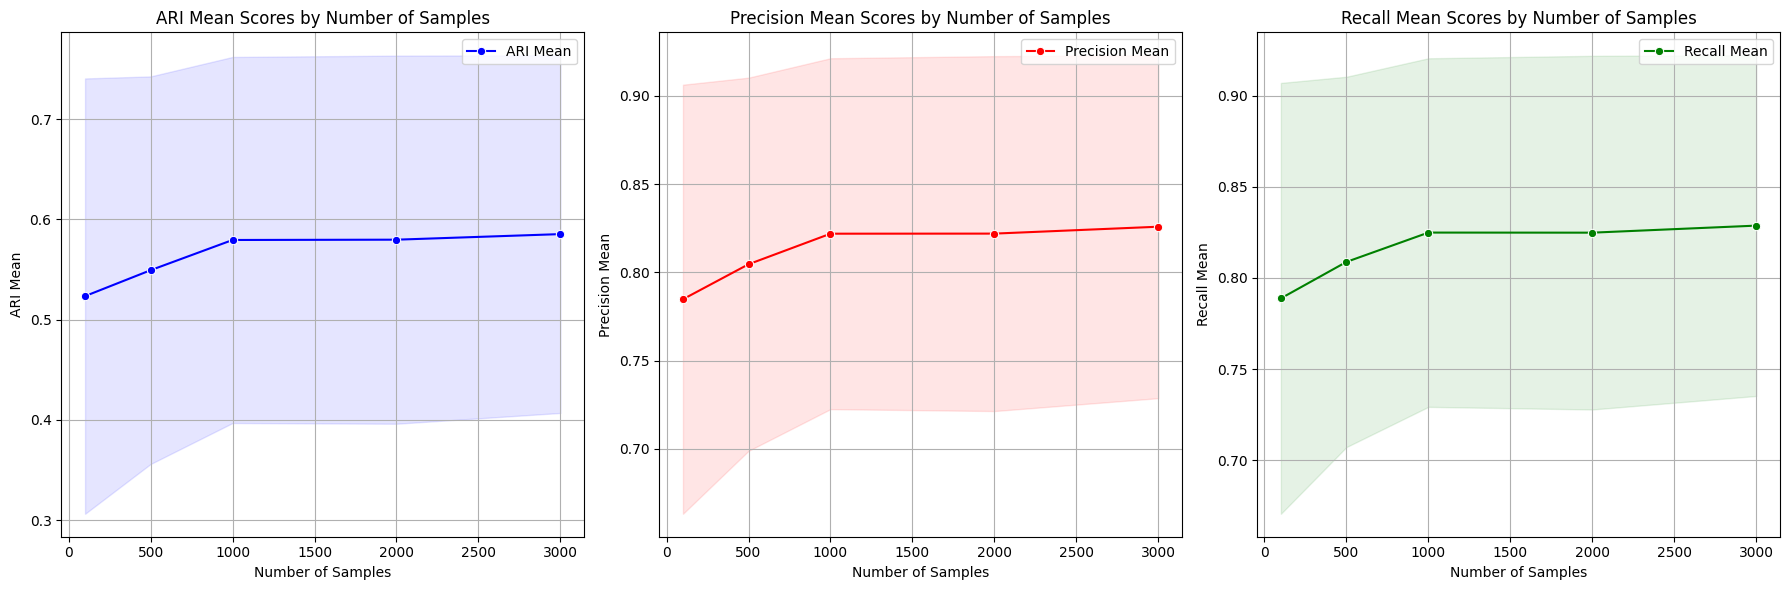

In [14]:
# Plotting ARI, Precision, and Recall on three subplots in one line for comparison with distinctive colors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
df_samples = df
# ARI plot
sns.lineplot(ax=axes[0], x='nb_samples', y='ARI_mean', data=df_samples, marker='o', color='blue', label='ARI Mean')
axes[0].fill_between(df_samples['nb_samples'], df_samples['ARI_mean'] - df_samples['ARI_std'], df_samples['ARI_mean'] + df_samples['ARI_std'], color='blue', alpha=0.1)
axes[0].set_title('ARI Mean Scores by Number of Samples')
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('ARI Mean')
axes[0].grid(True)

# Precision plot
sns.lineplot(ax=axes[1], x='nb_samples', y='Precision_mean', data=df_samples, marker='o', color='red', label='Precision Mean')
axes[1].fill_between(df_samples['nb_samples'], df_samples['Precision_mean'] - df_samples['Precision_std'], df_samples['Precision_mean'] + df_samples['Precision_std'], color='red', alpha=0.1)
axes[1].set_title('Precision Mean Scores by Number of Samples')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Precision Mean')
axes[1].grid(True)

# Recall plot
sns.lineplot(ax=axes[2], x='nb_samples', y='Recall_mean', data=df_samples, marker='o', color='green', label='Recall Mean')
axes[2].fill_between(df_samples['nb_samples'], df_samples['Recall_mean'] - df_samples['Recall_std'], df_samples['Recall_mean'] + df_samples['Recall_std'], color='green', alpha=0.1)
axes[2].set_title('Recall Mean Scores by Number of Samples')
axes[2].set_xlabel('Number of Samples')
axes[2].set_ylabel('Recall Mean')
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [26]:
# base parameters
n_samples = 1000
n_features = 6  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_strength = 0.5  
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)
K = n_clusters
seuil = 1e-7
p=3

ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["nb_features","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])
for nb_features in [6,12,18,24,36,64,128,256]:
    p = int(np.ceil(nb_features/4))
    print(p)
    print(nb_features)
    for i in range(50):
        np.random.seed(i)
        # Generate synthetic data with labels
        synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
            n_samples, nb_features, n_timepoints, n_clusters, correlation_strength, correlation_intra_cluster
        )
        X = synthetic_data
        y = cluster_labels
        y = np.array([str(i + 1) for i in y])
        X_df = pd.DataFrame(index=range(n_samples), columns=range(nb_features))
        for i in range(n_samples):
            for j in range(nb_features):
                X_df.at[i, j] = X[i, j, :]

      
        model = Mc2PCA(K, p, seuil, max_iter=50)
        idx_estimate, _, _ = model.fit(X_df)
        ari_score,precision,recall = metrics(y,idx_estimate)
        ari_scores.append(ari_score)
        precisions.append(precision)
        recalls.append(recall)       
     

    df.loc[len(df)] = [nb_features,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

print(df)
        

2
6


 22%|██▏       | 11/50 [00:00<00:02, 18.87it/s]


3
12


 16%|█▌        | 8/50 [00:00<00:02, 14.34it/s]


5
18


  8%|▊         | 4/50 [00:00<00:04, 10.08it/s]


6
24


  8%|▊         | 4/50 [00:00<00:04,  9.32it/s]


9
36


 18%|█▊        | 9/50 [00:01<00:05,  8.07it/s]


16
64


  6%|▌         | 3/50 [00:01<00:16,  2.85it/s]


32
128


  6%|▌         | 3/50 [00:02<00:34,  1.37it/s]


64
256


  6%|▌         | 3/50 [00:08<02:14,  2.86s/it]

   nb_features  ARI_mean   ARI_std  Precision_mean  Precision_std  \
0          6.0  0.384671  0.157781        0.715480       0.113414   
1         12.0  0.651902  0.297466        0.842190       0.154526   
2         18.0  0.764125  0.293525        0.892653       0.147158   
3         24.0  0.820323  0.274950        0.917845       0.136660   
4         36.0  0.851924  0.258316        0.931692       0.128487   
5         64.0  0.865945  0.246597        0.935567       0.126147   
6        128.0  0.870364  0.240193        0.934537       0.127465   
7        256.0  0.879713  0.232109        0.937795       0.125358   

   Recall_mean  Recall_std  
0     0.720380    0.106410  
1     0.846400    0.148475  
2     0.896393    0.141042  
3     0.921470    0.130152  
4     0.936188    0.120564  
5     0.946173    0.112547  
6     0.952729    0.105884  
7     0.958257    0.100402  


In [27]:
df

,nb_features,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,6.0,0.384671,0.157781,0.715480,0.113414,0.720380,0.106410
1,12.0,0.651902,0.297466,0.842190,0.154526,0.846400,0.148475
2,18.0,0.764125,0.293525,0.892653,0.147158,0.896393,0.141042
3,24.0,0.820323,0.274950,0.917845,0.136660,0.921470,0.130152
4,36.0,0.851924,0.258316,0.931692,0.128487,0.936188,0.120564
5,64.0,0.865945,0.246597,0.935567,0.126147,0.946173,0.112547
6,128.0,0.870364,0.240193,0.934537,0.127465,0.952729,0.105884
7,256.0,0.879713,0.232109,0.937795,0.125358,0.958257,0.100402


In [28]:
df.to_csv("results/results_artificial_nbfeatures.csv")

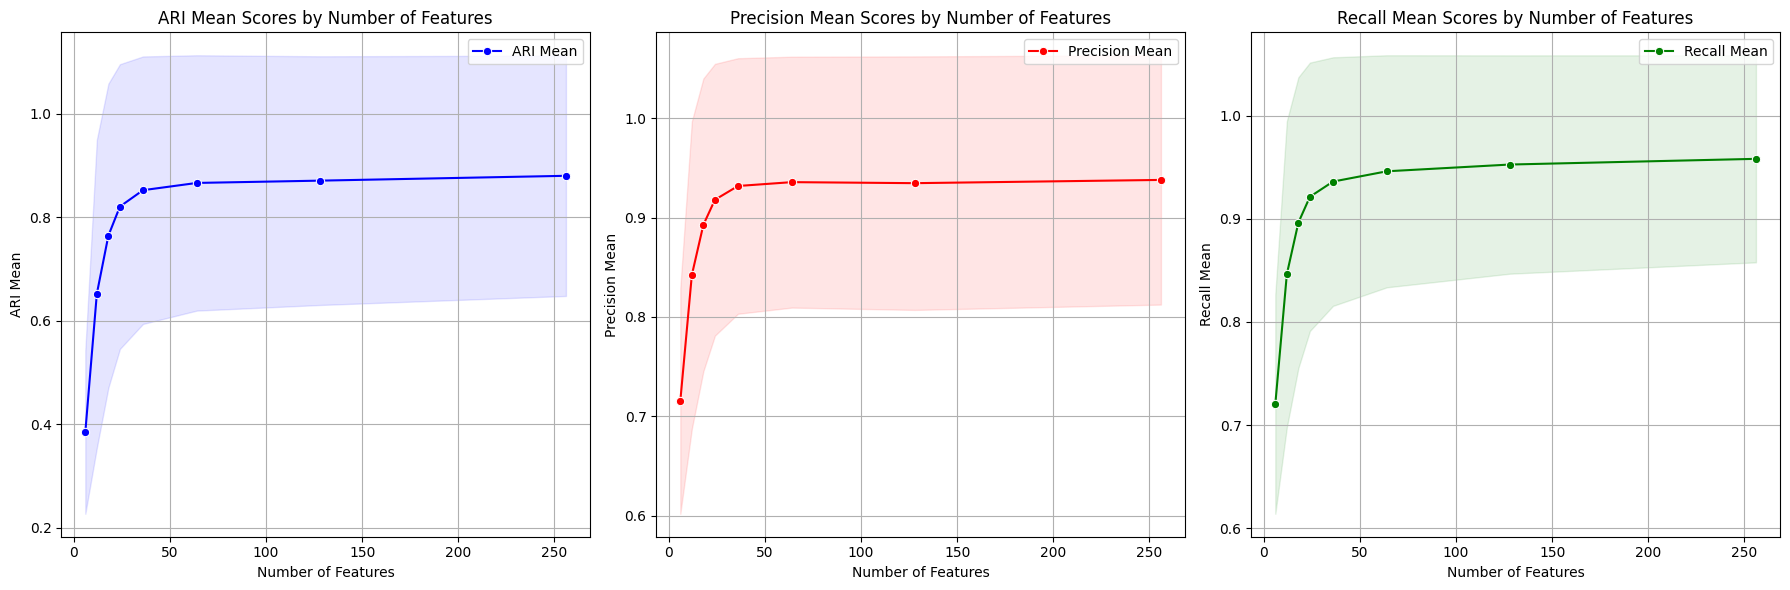

In [30]:
# Plotting ARI, Precision, and Recall on three subplots in one line for comparison with distinctive colors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
df_samples = df
# ARI plot
sns.lineplot(ax=axes[0], x='nb_features', y='ARI_mean', data=df_samples, marker='o', color='blue', label='ARI Mean')
axes[0].fill_between(df_samples['nb_features'], df_samples['ARI_mean'] - df_samples['ARI_std'], df_samples['ARI_mean'] + df_samples['ARI_std'], color='blue', alpha=0.1)
axes[0].set_title('ARI Mean Scores by Number of Features')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('ARI Mean')
axes[0].grid(True)

# Precision plot
sns.lineplot(ax=axes[1], x='nb_features', y='Precision_mean', data=df_samples, marker='o', color='red', label='Precision Mean')
axes[1].fill_between(df_samples['nb_features'], df_samples['Precision_mean'] - df_samples['Precision_std'], df_samples['Precision_mean'] + df_samples['Precision_std'], color='red', alpha=0.1)
axes[1].set_title('Precision Mean Scores by Number of Features')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Precision Mean')
axes[1].grid(True)

# Recall plot
sns.lineplot(ax=axes[2], x='nb_features', y='Recall_mean', data=df_samples, marker='o', color='green', label='Recall Mean')
axes[2].fill_between(df_samples['nb_features'], df_samples['Recall_mean'] - df_samples['Recall_std'], df_samples['Recall_mean'] + df_samples['Recall_std'], color='green', alpha=0.1)
axes[2].set_title('Recall Mean Scores by Number of Features')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Recall Mean')
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [31]:
# base parameters
n_samples = 1000
n_features = 6  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_strength = 0.5  
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)
K = n_clusters
seuil = 1e-7
p=3

ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["nb_features","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])
for nb_features in [6,12,18,24,36,64,128,256]:
    p = 4
    print(p)
    print(nb_features)
    for i in range(50):
        np.random.seed(i)
        # Generate synthetic data with labels
        synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
            n_samples, nb_features, n_timepoints, n_clusters, correlation_strength, correlation_intra_cluster
        )
        X = synthetic_data
        y = cluster_labels
        y = np.array([str(i + 1) for i in y])
        X_df = pd.DataFrame(index=range(n_samples), columns=range(nb_features))
        for i in range(n_samples):
            for j in range(nb_features):
                X_df.at[i, j] = X[i, j, :]

      
        model = Mc2PCA(K, p, seuil, max_iter=50)
        idx_estimate, _, _ = model.fit(X_df)
        ari_score,precision,recall = metrics(y,idx_estimate)
        ari_scores.append(ari_score)
        precisions.append(precision)
        recalls.append(recall)       
     

    df.loc[len(df)] = [nb_features,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

print(df)
        

4
6


 36%|███▌      | 18/50 [00:00<00:01, 18.46it/s]


4
12


 14%|█▍        | 7/50 [00:00<00:03, 13.27it/s]


4
18


 10%|█         | 5/50 [00:00<00:04, 10.80it/s]


4
24


  8%|▊         | 4/50 [00:00<00:04,  9.40it/s]


4
36


 56%|█████▌    | 28/50 [00:04<00:03,  6.57it/s]


4
64


  8%|▊         | 4/50 [00:01<00:15,  3.04it/s]


4
128


  4%|▍         | 2/50 [00:01<00:40,  1.18it/s]


4
256


  6%|▌         | 3/50 [00:08<02:16,  2.90s/it]

   nb_features  ARI_mean   ARI_std  Precision_mean  Precision_std  \
0          6.0  0.653804  0.158980        0.854500       0.090030   
1         12.0  0.802625  0.195714        0.917380       0.096075   
2         18.0  0.864347  0.187477        0.942760       0.089712   
3         24.0  0.895458  0.175416        0.955435       0.083878   
4         36.0  0.914160  0.164949        0.963064       0.079153   
5         64.0  0.916156  0.168354        0.961917       0.084832   
6        128.0  0.917557  0.170687        0.960971       0.089051   
7        256.0  0.923367  0.166173        0.962663       0.088851   

   Recall_mean  Recall_std  
0     0.857180    0.084099  
1     0.920990    0.088452  
2     0.946107    0.081563  
3     0.958810    0.074744  
4     0.966416    0.069272  
5     0.969123    0.066362  
6     0.971254    0.063697  
7     0.974530    0.060502  


In [34]:
df.to_csv("results/results_artificial_nbfeatures_p4.csv")

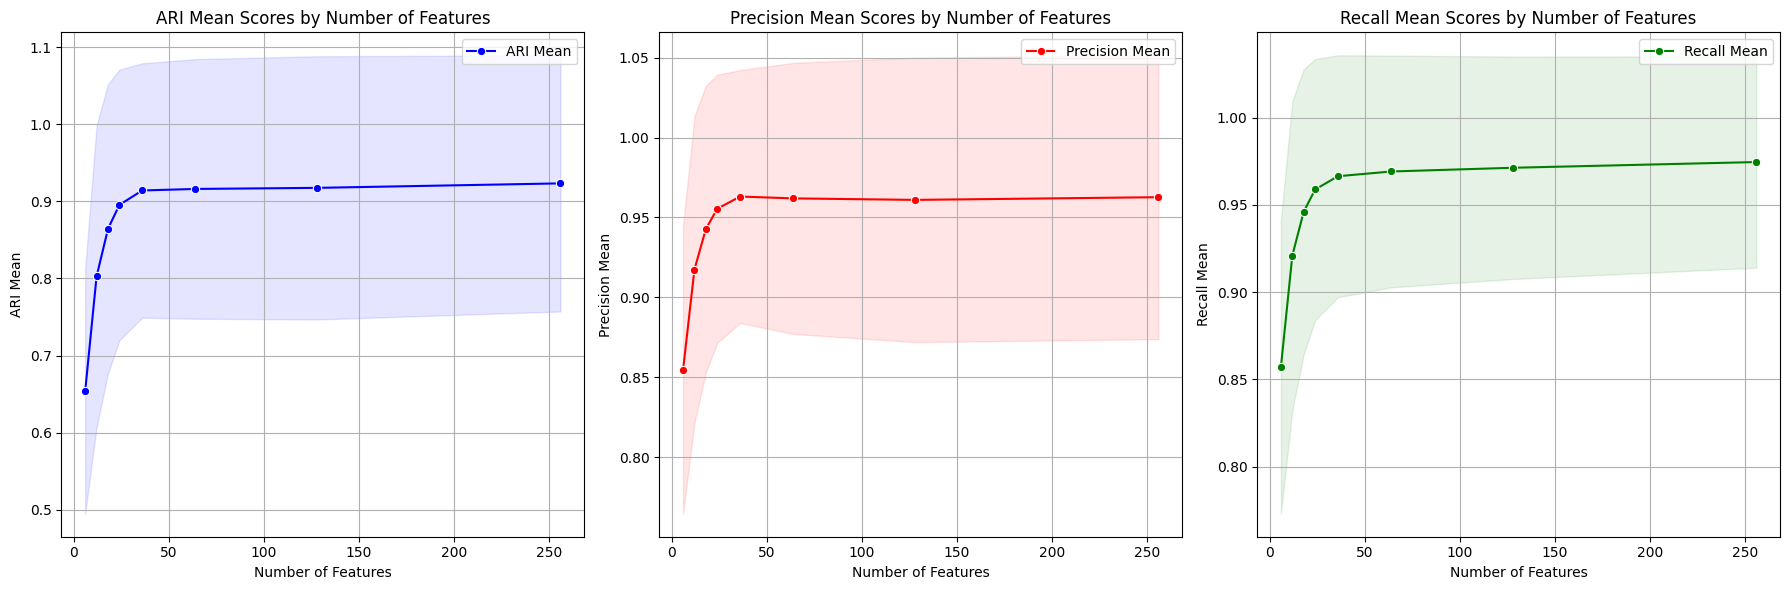

In [33]:
# Plotting ARI, Precision, and Recall on three subplots in one line for comparison with distinctive colors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
df_samples = df
# ARI plot
sns.lineplot(ax=axes[0], x='nb_features', y='ARI_mean', data=df_samples, marker='o', color='blue', label='ARI Mean')
axes[0].fill_between(df_samples['nb_features'], df_samples['ARI_mean'] - df_samples['ARI_std'], df_samples['ARI_mean'] + df_samples['ARI_std'], color='blue', alpha=0.1)
axes[0].set_title('ARI Mean Scores by Number of Features')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('ARI Mean')
axes[0].grid(True)

# Precision plot
sns.lineplot(ax=axes[1], x='nb_features', y='Precision_mean', data=df_samples, marker='o', color='red', label='Precision Mean')
axes[1].fill_between(df_samples['nb_features'], df_samples['Precision_mean'] - df_samples['Precision_std'], df_samples['Precision_mean'] + df_samples['Precision_std'], color='red', alpha=0.1)
axes[1].set_title('Precision Mean Scores by Number of Features')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Precision Mean')
axes[1].grid(True)

# Recall plot
sns.lineplot(ax=axes[2], x='nb_features', y='Recall_mean', data=df_samples, marker='o', color='green', label='Recall Mean')
axes[2].fill_between(df_samples['nb_features'], df_samples['Recall_mean'] - df_samples['Recall_std'], df_samples['Recall_mean'] + df_samples['Recall_std'], color='green', alpha=0.1)
axes[2].set_title('Recall Mean Scores by Number of Features')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Recall Mean')
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [36]:
# base parameters
n_samples = 1000
n_features = 6  # Must be an even number for pairwise correlations
n_timepoints = 50
n_clusters = 3  # Number of clusters
correlation_strength = 0.5  
correlation_intra_cluster = 1.1 # 0 means no correlation within clusters, 2 means all the times series in a cluster are identical by feature (up to a little noise)

seuil = 1e-7
p=4

ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["n_clusters","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])
for n_clusters in [3,10,25,50,100]:
    K = n_clusters
    print(K)
    for i in range(50):
        np.random.seed(i)
        # Generate synthetic data with labels
        synthetic_data, cluster_labels = generate_correlated_time_series_with_labels(
            n_samples, n_features, n_timepoints, n_clusters, correlation_strength, correlation_intra_cluster
        )
        X = synthetic_data
        y = cluster_labels
        y = np.array([str(i + 1) for i in y])
        X_df = pd.DataFrame(index=range(n_samples), columns=range(n_features))
        for i in range(n_samples):
            for j in range(n_features):
                X_df.at[i, j] = X[i, j, :]
      
        model = Mc2PCA(K, p, seuil, max_iter=50)
        idx_estimate, _, _ = model.fit(X_df)
        ari_score,precision,recall = metrics(y,idx_estimate)
        ari_scores.append(ari_score)
        precisions.append(precision)
        recalls.append(recall)       
     

    df.loc[len(df)] = [nb_features,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

print(df)
        

3


 36%|███▌      | 18/50 [00:01<00:01, 16.21it/s]


10


 38%|███▊      | 19/50 [00:03<00:06,  5.06it/s]


25


 40%|████      | 20/50 [00:13<00:19,  1.52it/s]


50


 22%|██▏       | 11/50 [00:13<00:47,  1.21s/it]


KeyboardInterrupt: 